In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from threeML import *
import numpy as np
from threeML.plugins import *
from skylab.datasets import Datasets
from astropy import units as u
from imp import reload
import scipy.optimize
import mla.core
import mla.injection
import mla.spectral
import warnings
import numpy.lib.recfunctions as rf
warnings.filterwarnings("ignore")
from skylab.ps_llh import PointSourceLLH
from skylab.llh_models import PowerLawLLH,EnergyLLH
import logging
skylab_logger = logging.getLogger('skylab')
skylab_logger.setLevel(logging.CRITICAL)

import os, sys, glob, abc

def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

# Where is the dataset stored?
dataset = "/data/i3store/users/mjlarson/student_data"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
exp = read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
mc = read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
#exp['angErr'][exp['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
#mc['angErr'][mc['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)

exp['ra']=np.random.uniform(0,2*np.pi,size=len(exp))
grl = np.load("/data/i3store/users/mjlarson/student_data/GRL/IC86_2012_exp.npy")
livetime = np.sum(grl['livetime'])
exp=rf.append_fields(exp.copy(),
                           'sigma',
                           exp['angErr'],
                           dtypes=np.float32)
mc=rf.append_fields(mc.copy(),
                           'sigma',
                           mc['angErr'],
                           dtypes=np.float32)
exp=rf.append_fields(exp.copy(),
                           'sinDec',
                           np.sin(exp['dec']),
                           dtypes=np.float32)
mc=rf.append_fields(mc.copy(),
                           'sinDec',
                           np.sin(mc['dec']),
                           dtypes=np.float32)


Bad key "text.kerning_factor" on line 4 in
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/data/disk01/home/jasonfan/threeML/threeML/__init__.py:12: UserWarning: No DISPLAY variable set. Using backend for graphics without display (Agg)
  warnings.warn("No DISPLAY variable set. Using backend for graphics without display (Agg)")
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/parameter.py:555: UserWarning: We have set the min_value of K to 1e-99 because there was a postive transform
  warnings.warn('We have set the min_value of %s to 1e-99 because there was a postive transform' % self.path)
/data/disk01/home/jasonfan/miniconda3/envs/p3/lib/python3.6/site-packages/astromodels/core/paramet

In [2]:
ra=np.radians(83.63)
dec=np.radians(22.0145)

In [3]:
sp=mla.spectral.PowerLaw(1e3 , 1e-9 , -2)
injector=mla.injection.PSinjector(sp,mc,background_time_profile = (56224,56324))
injector.set_backround(exp,grl,background_window=100)
injector.set_source_location(np.radians(83.63) ,np.radians(22.0145) )

In [4]:

testskylab_model=EnergyLLH()
testskylab=PointSourceLLH.upscale(exp,mc,(livetime,100),testskylab_model,seed=1)

In [5]:
testskylab.fit_source(ra,dec)

(0.0, {'nsignal': 0.0, 'gamma': 2.381880399447072})

In [6]:
testskylab.pseudo_experiment(inject=injector.sample_nevents(10))
testskylab.fit_source(ra,dec)

(48.53628577726455,
 {'nsignal': 14.854545378127645, 'gamma': 2.1387827681533316})

In [7]:
in_ns=np.arange(5,101)
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        testskylab.pseudo_experiment(inject=injector.sample_nevents(inject_ns))
        tempresult=testskylab.fit_source(ra,dec,inject=injector.sample_nevents(ns))
        result.append((inject_ns,tempresult[1]['gamma'],tempresult[1]['nsignal'],tempresult[0]))
    return np.array(result)

In [ ]:
from multiprocessing import Pool
p=Pool(30)
warnings.filterwarnings("ignore")
allresult=p.map(injectns,in_ns)

allresult=np.array(allresult)
np.save("allresult_skylab.npy",allresult)
p.close()

In [9]:
gamma_list=[]
ts_list=[]
ns_list=[]
for i in range(allresult.shape[0]):
    ns_inject=allresult[i][0][0]
    gamma=allresult[i][:,1]
    ts=(-allresult[i][:,3])
    ns=allresult[i][:,2]
    gamma_list.append(np.array([gamma.mean(),gamma.std()]))
    ts_list.append(np.array([ts.mean(),ts.std()]))
    ns_list.append(np.array([ns.mean(),ts.std()]))

    
gamma_list=np.array(gamma_list)
ts_list=np.array(ts_list)
ns_list=np.array(ns_list)

In [11]:
sp=mla.spectral.PowerLaw(1e3 , 1e-9 , -2.5)
injector=mla.injection.PSinjector(sp,mc,background_time_profile = (56224,56324))
injector.set_backround(exp,grl,background_window=100)
injector.set_source_location(np.radians(83.63) ,np.radians(22.0145) )
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        testskylab.pseudo_experiment(inject=injector.sample_nevents(inject_ns))
        tempresult=testskylab.fit_source(ra,dec,inject=injector.sample_nevents(ns))
        result.append((inject_ns,tempresult[1]['gamma'],tempresult[1]['nsignal'],tempresult[0]))
    return np.array(result)
p=Pool(30)
allresult25=p.map(injectns,in_ns)
allresult25=np.array(allresult25)
np.save("allresult2.5_skylab.npy",allresult25)
p.close()


gamma_list25=[]
ts_list25=[]
ns_list25=[]
for i in range(allresult25.shape[0]):
    ns_inject=allresult25[i][0][0]
    gamma=allresult25[i][:,1]
    ts=(-allresult25[i][:,3])
    ns=allresult25[i][:,2]
    gamma_list25.append(np.array([gamma.mean(),gamma.std()]))
    ts_list25.append(np.array([ts.mean(),ts.std()]))
    ns_list25.append(np.array([ns.mean(),ts.std()]))

    
gamma_list25=np.array(gamma_list25)
ts_list25=np.array(ts_list25)
ns_list25=np.array(ns_list25)


sp=mla.spectral.PowerLaw(1e3 , 1e-9 , -3)
injector=mla.injection.PSinjector(sp,mc,background_time_profile = (56224,56324))
injector.set_backround(exp,grl,background_window=100)
injector.set_source_location(np.radians(83.63) ,np.radians(22.0145) )
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        testskylab.pseudo_experiment(inject=injector.sample_nevents(inject_ns))
        tempresult=testskylab.fit_source(ra,dec,inject=injector.sample_nevents(ns))
        result.append((inject_ns,tempresult[1]['gamma'],tempresult[1]['nsignal'],tempresult[0]))
    return np.array(result)
p=Pool(30)
allresult3=p.map(injectns,in_ns)
allresult3=np.array(allresult3)
np.save("allresult3_skylab.npy",allresult3)
p.close()


gamma_list3=[]
ts_list3=[]
ns_list3=[]
for i in range(allresult3.shape[0]):
    ns_inject=allresult3[i][0][0]
    gamma=allresult3[i][:,1]
    ts=(-allresult3[i][:,3])
    ns=allresult3[i][:,2]
    gamma_list3.append(np.array([gamma.mean(),gamma.std()]))
    ts_list3.append(np.array([ts.mean(),ts.std()]))
    ns_list3.append(np.array([ns.mean(),ts.std()]))

    
gamma_list3=np.array(gamma_list3)
ts_list3=np.array(ts_list3)
ns_list3=np.array(ns_list3)


NameError: name 'testmla' is not defined

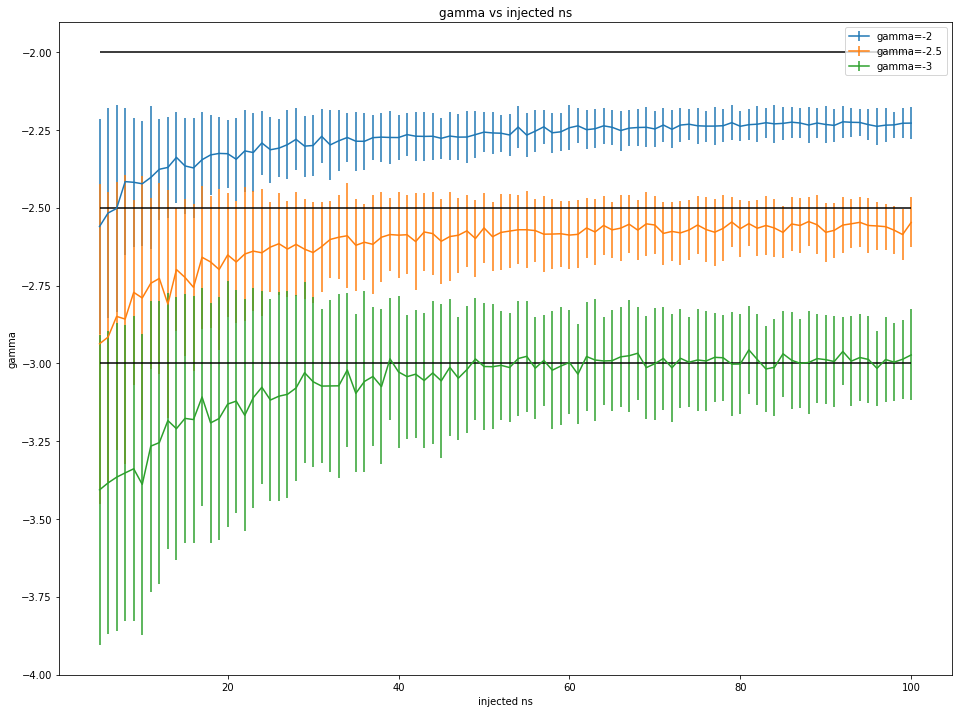

In [51]:
fig, ax = plt.subplots(figsize=(16,12))


ax.errorbar(in_ns, gamma_list[:,0],
            yerr=gamma_list[:,1],
            fmt='-',label="gamma=-2")


ax.hlines(-2,5,100)
ax.errorbar(in_ns, gamma_list25[:,0],
            yerr=gamma_list25[:,1],
            fmt='-',label="gamma=-2.5")
ax.hlines(-2.5,5,100)
ax.errorbar(in_ns, gamma_list3[:,0],
            yerr=gamma_list3[:,1],
            fmt='-',label="gamma=-3")
ax.hlines(-3,5,100)
ax.set_xlabel("injected ns")
ax.set_ylabel("gamma")
ax.set_title("gamma vs injected ns")
ax.legend()

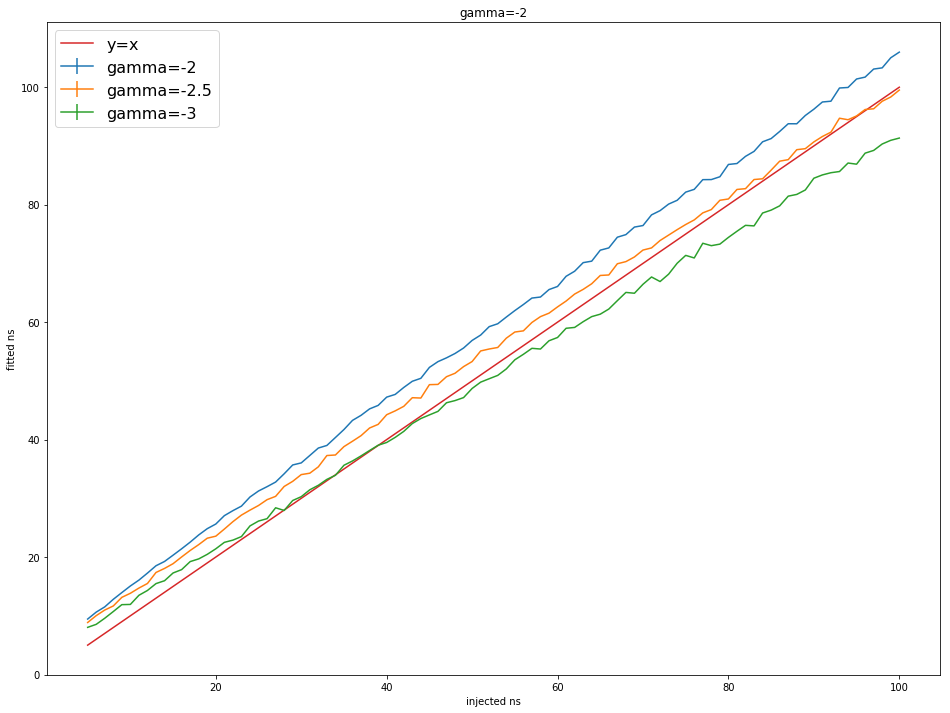

In [54]:
fig, ax = plt.subplots(figsize=(16,12))


# ax.errorbar(in_ns, ns_list[:,0],
#             yerr=ns_list[:,1],
#             fmt='-',label="gamma=-2")
# ax.errorbar(in_ns, ns_list25[:,0],
#             yerr=ns_list25[:,1],
#             fmt='-',label="gamma=-2.5")

# ax.errorbar(in_ns, ns_list3[:,0],
#             yerr=ns_list3[:,1],
#             fmt='-',label="gamma=-3")
ax.errorbar(in_ns, ns_list[:,0],
            yerr=0,
            fmt='-',label="gamma=-2")
ax.errorbar(in_ns, ns_list25[:,0],
            yerr=0,
            fmt='-',label="gamma=-2.5")

ax.errorbar(in_ns, ns_list3[:,0],
            yerr=0,
            fmt='-',label="gamma=-3")


x=np.linspace(5,100,1000)
ax.plot(x,x,label="y=x")
ax.set_xlabel("injected ns")
ax.set_ylabel("fitted ns")
ax.set_title("gamma=-2")
ax.legend(fontsize=16)